In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import dotenv
import os
import gc
import cv2

dotenv.load_dotenv('.env')

True

In [2]:
train = pd.read_csv('raw/train.csv').set_index('id')
test = pd.read_csv('raw/sample_submission.csv').set_index('id')
depths = pd.read_csv('raw/depths.csv').set_index('id')

train = pd.merge(train, depths, left_index=True, right_index=True, how='inner')
train.shape, test.shape, depths.shape

((4000, 2), (18000, 1), (22000, 1))

In [0]:
IMG_SIZE = 128

In [4]:
X_train = [cv2.resize(cv2.imread("./raw/images/{}.png".format(idx), cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE)) for idx in tqdm(train.index)]
X_train = np.expand_dims(np.array(X_train), -1)
X_train = X_train / 255
X_train = X_train.astype(np.float32)

y_train = [cv2.resize(cv2.imread("./raw/masks/{}.png".format(idx), cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE)) for idx in tqdm(train.index)]
y_train = np.expand_dims(np.array(y_train), -1)
y_train = y_train / 255
y_train = y_train.astype(np.float32)


X_test = [cv2.resize(cv2.imread("./raw/images/{}.png".format(idx), cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE)) for idx in tqdm(test.index)]
X_test = np.expand_dims(np.array(X_test), -1)
X_test = X_test / 255
X_test = X_test.astype(np.float32)


X_train.shape, y_train.shape, X_test.shape

100%|██████████| 18000/18000 [00:06<00:00, 2769.43it/s]


((4000, 128, 128, 1), (4000, 128, 128, 1), (18000, 128, 128, 1))

In [5]:
from tensorflow import keras
from tensorflow.keras.layers import *
import tensorflow as tf
# from keras import Model
# from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# from keras.models import load_model
# from keras.optimizers import Adam
# from keras.utils.vis_utils import plot_model
# from keras.preprocessing.image import ImageDataGenerator
# from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, Dropout, BatchNormalization, SpatialDropout2D, UpSampling2D, Activation, Add

# from keras import backend as K



def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score
  
  

# define iou or jaccard loss function
def jaccard_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    
    epsilon = tf.keras.backend.epsilon()
    
    score = (intersection + epsilon) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + epsilon)
    return 1 - score

  
def custom_loss(y_true, y_pred):
    return jaccard_loss(y_true, y_pred) + dice_loss(y_true, y_pred) + tf.keras.losses.binary_crossentropy(y_true, y_pred)
  

# input: (x, 101, 101, 1), (x, 101, 101, 1)
# output: (x,)
def batch_iou(y_true, y_pred):
    pred_ = tf.round(y_pred)
    truth_ = y_true
    
    i = tf.reduce_sum(pred_ * truth_, axis=[1,2,3])
    u = tf.reduce_sum((pred_ + truth_) - (pred_ * truth_), axis=[1,2,3])
    
    epsilon = tf.keras.backend.epsilon()
    return (i + epsilon) / (u + epsilon)

# input: (x,)
# output: ()
def mean_iou(y_true, y_pred):
    ious = batch_iou(y_true, y_pred)
    ious = tf.reshape(ious, (-1,1))
    ious = tf.tile(ious, (1,10))
    thresholds = tf.range(0.5, 1.0, delta=0.05)
    
    return tf.reduce_mean(tf.to_float(ious >= thresholds))


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard
  
  
  
def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss
  
  
def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        #loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        loss = tf.tensordot(tf.nn.elu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss
  
  
def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

  
def lovasz_loss(y_true, y_pred):
    y_true, y_pred = tf.cast(tf.squeeze(y_true, -1), tf.int32), tf.cast(tf.squeeze(y_pred, -1), tf.float32)
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss
  

# def iou_bce_loss(y_true, y_pred):
#     return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * jaccard_loss(y_true, y_pred)
  
  
# def mean_iou(y_true, y_pred):
#     return tf.reduce_mean(tf.to_float(tf.greater(tf.round(y_true), y_pred)))
    

# def mean_iou(y_true, y_pred):
#     i = tf.round(y_pred) * tf.round(y_true)
#     o = tf.round(y_pred) * tf.round(y_true)
#     mean_iou = tf.metrics.mean_iou(y_true, tf.round(y_pred), 1)
#     print(mean_iou)
#     print(tf.tile(mean_iou, 10))
#     print(mean_iou[0])
#     return mean_iou[0]
#     return tf.reduce_mean(tf.tile(mean_iou, 10))
  
# def mean_iou(y_true, y_pred):
#     prec = []
#     for t in np.arange(0.5, 1.0, 0.05):
#         y_pred_ = tf.to_int32(y_pred > t)
#         score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
#         K.get_session().run(tf.local_variables_initializer())
#         with tf.control_dependencies([up_opt]):
#             score = tf.identity(score)
#         prec.append(score)
#     return K.mean(K.stack(prec), axis=0)


# def convolution_block(x, filters, size):
#     return x



  
# def residual_block(blockInput, filters):
#     x = Conv2D(filters, 3, strides=(1,1), padding='same', activation=None)(blockInput)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Conv2D(filters, 3, strides=(1,1), padding='same', activation=None)(x)
#     x = Add()([x, blockInput])
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     return x
  
  
# def res_block(i, filters=16):
#     n1 = Conv2D(filters, 1, activation='relu', padding='same')(i)
#     n3 = Conv2D(filters, 3, activation='relu', padding='same')(i)
#     n5 = Conv2D(filters, 5, activation='relu', padding='same')(i)
#     n = Concatenate()([n1, n3, n5])
#     n = BatchNormalization()(n)
    
#     n1 = Conv2D(filters, 1, activation='relu', padding='same')(n)
#     n3 = Conv2D(filters, 3, activation='relu', padding='same')(n)
#     n5 = Conv2D(filters, 5, activation='relu', padding='same')(n)
#     n = Concatenate()([n1, n3, n5])
#     n = BatchNormalization()(n)
    
# #     n = Conv2D(1, 1, activation='relu', padding='same')(n)
# #     n = Concatenate()([i, n])
# #     n = BatchNormalization()(n)
#     return n

  
# def level_block(inp, dim, depth, inc, acti, do, bn, mp, up, res):
#     if depth > 0:
#         n = conv_block(m, dim, acti, bn, res)
#         m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
#         m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
#         if up:
#             m = UpSampling2D()(m)
#             m = Conv2D(dim, 2, activation=acti, padding='same')(m)
#         else:
# #             padding = ['valid', 'same','same','valid','same','valid']
#             padding = ['same','same','valid','same','valid']
#             m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding=padding[depth-1])(m)
#         n = Concatenate()([n, m])
#         m = conv_block(n, dim, acti, bn, res)
#     else:
#         m = conv_block(m, dim, acti, bn, res, do=do)
#     return m

  
# def ResNet():
#     filter_size = 8
#     i = Input(shape=(img_size_target,img_size_target,1))
#     o = Conv2D(filter_size, 1, strides=(1,1), padding='same', activation='relu')(i)
#     for depth in tqdm(range(128)):
#       o = residual_block(o, filter_size)
#     o = Conv2D(1, 1, strides=(1,1), padding='same', activation='sigmoid')(o)
#     return Model(inputs=i, outputs=o)
  
  
# def ResNet_2():
#     resnet = keras.applications.resnet50.ResNet50(include_top=False, pooling=None, input_shape=(IMG_SIZE, IMG_SIZE, 3))
#     o = Conv2D(1, 1, strides=(1,1), activation='sigmoid')(resnet.output)
#     return Model(inputs=resnet.input, outputs=o)
  
# Preserve original inputs in addition
# Normalize input
# Arbitary output
def res_block(inputs, filters, res=None):
    if res is not None:
      inputs = Add()([inputs, res])
    
    conv = BatchNormalization()(inputs)
    conv = Conv2D(filters, 3, strides=1, padding='same', activation='relu')(conv)
    
    conv = BatchNormalization()(conv)
    conv = Conv2D(filters, 3, strides=1, padding='same', activation='relu')(conv)
    
    return Add()([conv, inputs])
    
    
def down_sampling(inputs, filters):
    conv = BatchNormalization()(inputs)
    return Conv2D(filters, 3, strides=2, padding='same', activation='relu')(conv)

  
def up_sampling(inputs, filters):
    conv = BatchNormalization()(inputs)
    return Conv2DTranspose(filters, 3, strides=2, padding='same', activation='relu')(conv)

  
def UNet(inputs, channels, depth):
    layers = [inputs]
    
    for i in range(depth):
      layers.append(res_block(layers[-1], channels))
      channels = channels * 2
      layers.append(down_sampling(layers[-1], channels))
      
    for i in range(depth):
      channels = channels // 2
      layers.append(up_sampling(layers[-1], channels))
      layers.append(res_block(layers[-1], channels, layers[(depth - i - 1) * 2 + 1]))
      
    return layers[-1]

    

def build_model(channels=2, depth=6):
    inp = keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    l = BatchNormalization()(inp)
    l = Conv2D(channels, 3, strides=1, padding='same', activation='relu')(l)
    
    l = UNet(l, channels, depth)
#     l = UNet(l, channels, depth)
    
    l = BatchNormalization()(l)
    out = Conv2D(1, 1, strides=(1,1), padding='same', activation='sigmoid')(l)
    
    return keras.Model(inputs=inp, outputs=out)


  
build_model().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 1)  4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 2)  20          batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 2)  8           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (

In [0]:
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomContrast,
    RandomGamma,
    RandomBrightness
)

# def random_h_flip(image, mask):
#   aug = HorizontalFlip(p=0.5)
#   augmented = aug(image=image, mask=mask)
#   return augmented['image'], augmented['mask']


# def random_v_flip(image, mask):
#   aug = VerticalFlip(p=0.5)
#   augmented = aug(image=image, mask=mask)
#   return augmented['image'], augmented['mask']


# def random_rotate(image, mask):
#   aug = RandomRotate90(p=1)
#   augmented = aug(image=image, mask=mask)
#   return augmented['image'], augmented['mask']


# def random_aug(image, mask):
#   image, mask = random_h_flip(image, mask)
#   image, mask = random_v_flip(image, mask)
#   image, mask = random_rotate(image, mask)
#   return image, mask


SEED = 42

def _random_flip_left_right(image, mask):
  image = tf.image.random_flip_left_right(image, seed=SEED)
  mask = tf.image.random_flip_left_right(mask, seed=SEED)
  return image, mask

def _random_flip_up_down(image, mask):
  image = tf.image.random_flip_up_down(image, seed=SEED)
  mask = tf.image.random_flip_up_down(mask, seed=SEED)
  return image, mask


def _random_rotate(image, mask):
  random_k = tf.gather(tf.random_uniform((1,), 0, 3, dtype=tf.int32), 0)
  
  image = tf.image.rot90(image, random_k)
  mask = tf.image.rot90(mask, random_k)
  
  return image, mask


def _random_aug(image, mask):
  image, mask = _random_rotate(image, mask)
  image, mask = _random_flip_up_down(image, mask)
  image, mask = _random_flip_left_right(image, mask)
  
  return image, mask

In [7]:
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def build_train_generator(X_train, y_train, batch_size=32):
    # Ref: https://keras.io/preprocessing/image/
    # we create two instances with the same arguments
    data_gen_args = dict(
#       rotation_range=360.,
#       width_shift_range=0.1,
#       height_shift_range=0.1,
      fill_mode='reflect',
      horizontal_flip=True,
      vertical_flip=True
    )
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    # Provide the same seed and keyword arguments to the fit and flow methods
    seed = 1
    image_datagen.fit(X_train, augment=True, seed=seed)
    mask_datagen.fit(y_train, augment=True, seed=seed)
    
    image_generator = image_datagen.flow(X_train, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(y_train, batch_size=batch_size, seed=seed)

    # combine generators into one which yields image and masks
    return zip(image_generator, mask_generator)

  

def cv(X_train, y_train, X_test, fold, fast=False):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=fold, shuffle=True, random_state=42)
    
    loss = []
    metric = []
    pred_test = np.zeros(X_test.shape)
    fold_index = 0
    
    start_ch = 32
    depth = 5
         
    
    for train_index, test_index in kf.split(X_train):      
#       model = UNet((img_size_target,img_size_target,1),start_ch=start_ch,depth=depth,batchnorm=True, dropout=False)
      model = build_model()
  
      resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu='kaggle-tpu')
      strategy = tf.contrib.tpu.TPUDistributionStrategy(resolver)
      model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=strategy)
      session_master = resolver.master()
  
      model.compile(loss=jaccard_loss, optimizer="adam", metrics=[mean_iou, "binary_crossentropy"])
    
      EPOCHS = 20000
      BATCH_SIZE = 64

      def create_data_fn(index, training=False):
        def data_fn():
          dataset = tf.data.Dataset.from_tensor_slices((X_train[index], y_train[index]))
          dataset = dataset.shuffle(len(X_train[index])).prefetch(len(X_train[index]))
          if training:
            dataset = dataset.map(_random_aug)
          dataset = dataset.repeat(EPOCHS).batch(BATCH_SIZE, drop_remainder=True)
          return dataset
        return data_fn
          

      early_stopping = EarlyStopping(patience=10, verbose=1)
      model_checkpoint = ModelCheckpoint("./model/keras_%d.model"%fold_index, save_best_only=True, verbose=1)
      reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.00001, verbose=1)

      history = model.fit(
          create_data_fn(train_index, training=True),
          steps_per_epoch=int(np.ceil(len(X_train[train_index]) / BATCH_SIZE)),
          validation_data=create_data_fn(test_index, training=False),
          validation_steps=int(np.ceil(len(X_train[test_index]) / BATCH_SIZE)),
          epochs=EPOCHS
#           callbacks=[early_stopping, model_checkpoint, reduce_lr],
#           callbacks=[early_stopping, reduce_lr]
      )
      
      best_idx = np.argmin(history.history['val_loss'])
      val_loss = history.history['val_loss'][best_idx]
      val_mean_iou = history.history['val_mean_iou'][best_idx]
      
      print("Best val_loss: %.4f, val_mean_iou: %.4f"%(val_loss, val_mean_iou))
      loss.append(val_loss)
      metric.append(val_mean_iou)
      
      model = keras.models.load_model('model/keras_%d.model'%fold_index, custom_objects={'mean_iou': mean_iou, 'iou_bce_loss': iou_bce_loss, 'dice_loss': dice_loss})
      pred_test += model.predict(X_test) / fold
      fold_index = fold_index + 1
      
      del model
      gc.collect()
      
      if fast:
        break
      
      
    print('%d fold val_loss: %.4f, val_mean_iou: %.4f'%(fold, np.mean(loss), np.mean(metric)))
    return pred_test, np.mean(loss), np.mean(metric)

  
pred_test, val_loss, val_mean_iou = cv(X_train, y_train, X_test, 5, fast=False)

INFO:tensorflow:Querying Tensorflow master (grpc://10.240.1.2:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 6663566377396717378)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 13942164892030274946)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 16078935745895175414)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 2004692328121359120)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 10619227680240057337)
INFO:tensorflow:*** Available Device: _DeviceAttr

KeyboardInterrupt: ignored

In [4]:
import tensorflow as tf
import numpy as np

def test_model():
  x = tf.keras.layers.Input(shape=(101,101,1), dtype=np.float)
  y = tf.keras.layers.Conv2D(1,1, padding='same', activation='sigmoid', dtype=np.float)(x)
  m = tf.keras.Model(x, y)
  return m

model = test_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 101, 101, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 101, 101, 1)       2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [5]:
resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu='kaggle-tpu')
strategy = tf.contrib.tpu.TPUDistributionStrategy(resolver)
model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=strategy)
session_master = resolver.master()

INFO:tensorflow:Querying Tensorflow master (grpc://10.240.1.2:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 3016486000668466679)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 15929751603998571908)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 11527322124576356386)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 3881825627062303427)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2980788480538476407)
INFO:tensorflow:*** Available Device: _DeviceAttri

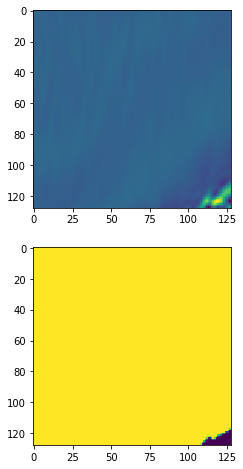

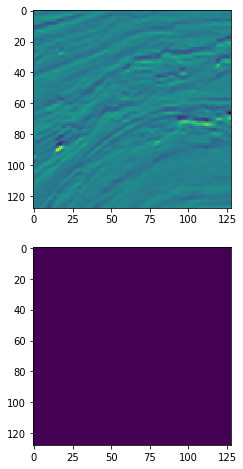

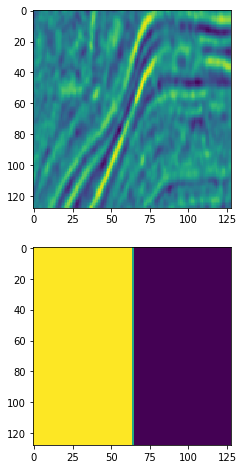

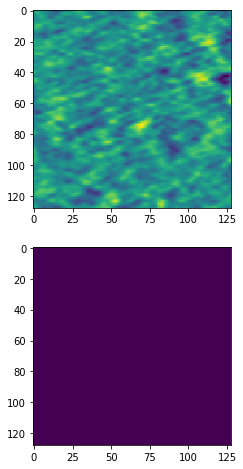

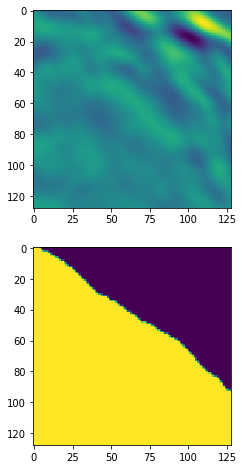

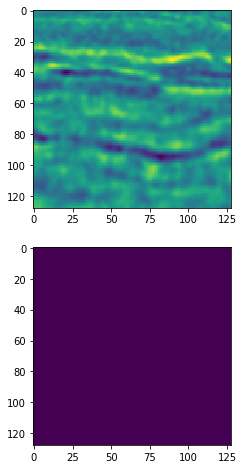

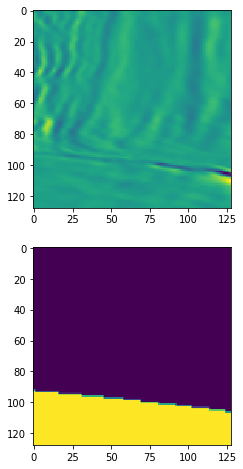

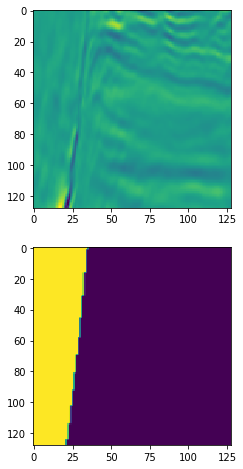

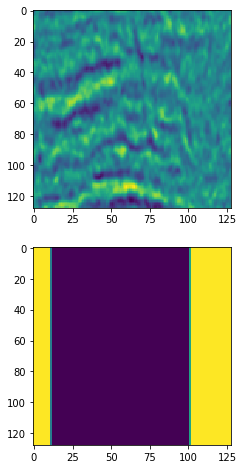

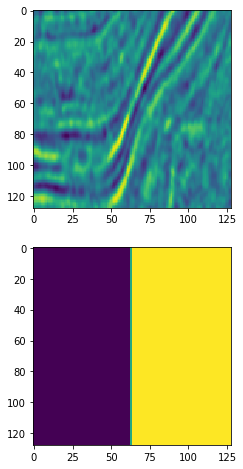

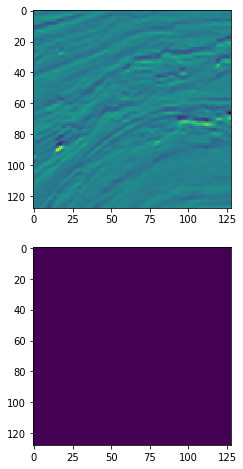

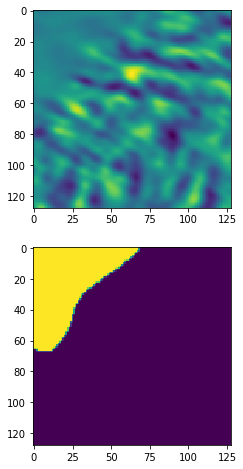

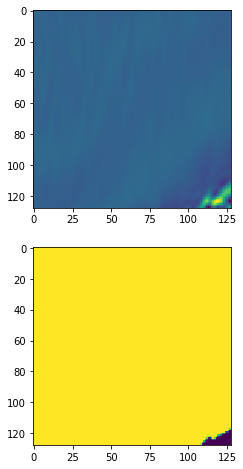

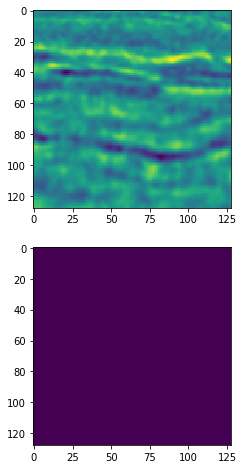

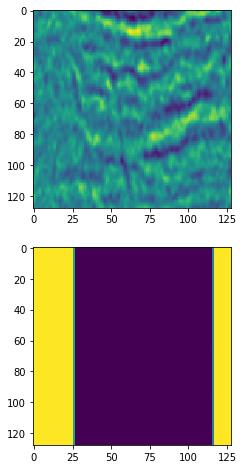

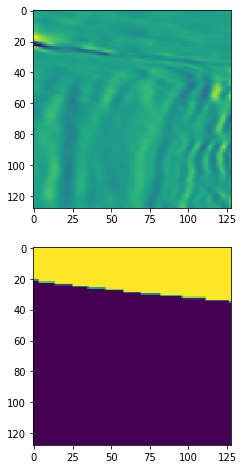

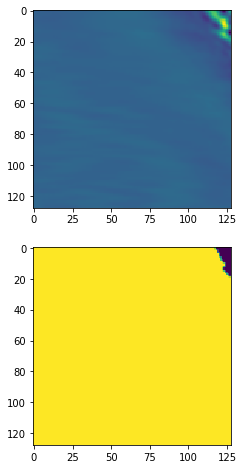

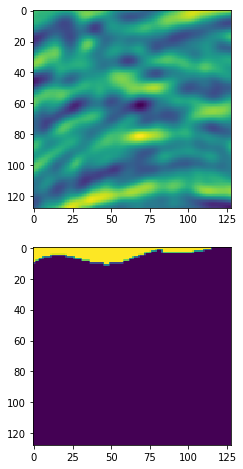

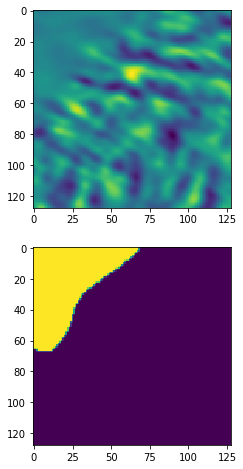

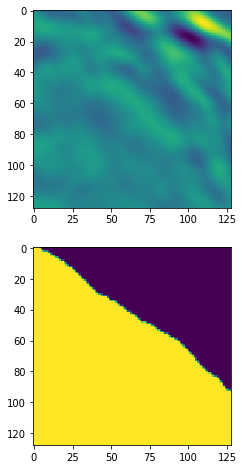

In [30]:
import matplotlib.pyplot as plt
import math

def visualize(image, mask, original_image=None, original_mask=None):
    
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)
        

SEED = 42

def _random_flip_left_right(image, mask):
  image = tf.image.random_flip_left_right(image, seed=SEED)
  mask = tf.image.random_flip_left_right(mask, seed=SEED)
  return image, mask

def _random_flip_up_down(image, mask):
  image = tf.image.random_flip_up_down(image, seed=SEED)
  mask = tf.image.random_flip_up_down(mask, seed=SEED)
  return image, mask


def _random_rotate(image, mask):
  random_k = tf.gather(tf.random_uniform((1,), 0, 3, dtype=tf.int32), 0)
  
  image = tf.image.rot90(image, random_k)
  mask = tf.image.rot90(mask, random_k)
  
  return image, mask


def _random_aug(image, mask):
  image, mask = _random_rotate(image, mask)
  image, mask = _random_flip_up_down(image, mask)
  image, mask = _random_flip_left_right(image, mask)
  
  return image, mask



def _set_shape(image, mask):
  image.set_shape([101, 101, 1])
  mask.set_shape([101, 101, 1])
  return image, mask

def input_fn():
#   images = tf.random_uniform([1024, 101, 101, 1])
#   masks = tf.random_uniform([1024, 101, 101, 1])
  
  dataset = tf.data.Dataset.from_tensor_slices((X_train[:10], y_train[:10]))
#   print(dataset)
#   dataset = dataset.map(lambda image, mask: tuple(tf.py_func(random_h_flip, [image, mask], [tf.float32, tf.float32])))
#   print(dataset)
  dataset = dataset.map(_random_aug)
#   print(dataset)
#   dataset = dataset.shuffle(3).repeat(100000).batch(3, drop_remainder=True)
  dataset = dataset.shuffle(100).repeat(100000).batch(3, drop_remainder=True)
#   print(dataset)

  return dataset

dataset = input_fn()
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

with tf.Session() as sess:
  sess.run(iterator.initializer)
  for j in range(10):
    image, mask = sess.run(next_element)
    for i in range(2):
      visualize(image[i].reshape(128, 128), mask[i].reshape(128, 128))

# # Typically `result` will be the output of a model, or an optimizer's
# # training operation.
# result = tf.add(next_element, next_element)

# sess = tf.
# sess.run(iterator.initializer)
# print(sess.run(result))  # ==> "0"
# print(sess.run(result))  # ==> "2"
# print(sess.run(result))  # ==> "4"
# print(sess.run(result))  # ==> "6"
# print(sess.run(result))  # ==> "8"
# try:
#   sess.run(result)
# except tf.errors.OutOfRangeError:
#   print("End of dataset")  # ==> "End of dataset"




In [5]:
import numpy as np

model.compile(
      optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.01),
      loss='binary_crossentropy',
      metrics=['binary_crossentropy'])



model.fit(
    input_fn,
    validation_data=input_fn,
    validation_steps=100,
    steps_per_epoch=100,
    epochs=20)

<TensorSliceDataset shapes: ((101, 101, 1), (101, 101, 1)), types: (tf.float32, tf.float32)>
<TensorSliceDataset shapes: ((101, 101, 1), (101, 101, 1)), types: (tf.float32, tf.float32)>
<MapDataset shapes: ((101, 101, 1), (101, 101, 1)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((32, 101, 101, 1), (32, 101, 101, 1)), types: (tf.float32, tf.float32)>
<TensorSliceDataset shapes: ((101, 101, 1), (101, 101, 1)), types: (tf.float32, tf.float32)>
<TensorSliceDataset shapes: ((101, 101, 1), (101, 101, 1)), types: (tf.float32, tf.float32)>
<MapDataset shapes: ((101, 101, 1), (101, 101, 1)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((32, 101, 101, 1), (32, 101, 101, 1)), types: (tf.float32, tf.float32)>
Epoch 1/20
INFO:tensorflow:New input shapes; (re-)compiling: mode=train, [TensorSpec(shape=(32, 101, 101, 1), dtype=tf.float32, name=None), TensorSpec(shape=(32, 101, 101, 1), dtype=tf.float32, name=None)]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflo

KeyboardInterrupt: ignored